Почему пользователи не заканчивают курс?

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(rc={'figure.figsize': (9, 6)})


### Анализ активности студентов онлайн курса "Введение в анализ данных в R" на https://stepik.org/

# Проблема:

# Много людей начинают проходить курс, мало заканчивают. Средний success rate 5-10%.
# Понять почему пользователи бросают курс и как сделать так, чтобы его не бросали.
# Предсказать уйдет ли пользователь с курса.
# Если пользователь собирается уйти, что надо сделать, чтобы он не ушел?

# Не меняя значительно курс, что можно исправить, чтобы добиться более высокого success rate?
# Проанализируем поведение студентов.
# Посмотрим как они проходят курс, как часто они его проходят. На каких степах были проблемы.
# Какие патерны и действия приводят к тому, что пользователь не доходит до конца.
# Какие наоборот приводят к тому, что он доходит.

# Как эту информацию можно использовать в дальнейшем, чтобы улучшить контент, улучшить продукт, увеличить метрику.

# Будем решать задачу классификации, студентов разделим на 2 класса - "не закончили курс", "закончили курс".
# Если мы обучим некоторую модель, которая начнет успешно предсказывать в самом начале пути студента,
# например, по его активности в течение первых нескольких дней закончит он курс или нет,
## это знание можно использовать, чтобы студента как-то направить в нужное русло. **bold text**





# event_data_train - действия, которые совершают студенты со стэпами.

#   step_id   - ID стэпа
#   user_id   - анонимизированный id юзера
#   timestamp - время наступления события в формате unix date
#   action    - событие, возможные значения:

#     discovered      - пользователь перешел на стэп
#     viewed          - просмотр шага
#     started_attempt - начало попытки решить шаг
#     passed          - удачное решение практического шага

In [ ]:
events = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip', compression ='zip')
events

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
...,...,...,...,...
3480698,33375,1526772685,viewed,11677
3480699,32815,1526772750,viewed,5198
3480700,32815,1526772750,discovered,5198
3480701,32815,1526772750,passed,5198


# submissions_data_train - данные о времени и статусах сабмитов к практическим заданиям.

#   step_id           - ID стэпа
#   timestamp         - время отправки решения в формате unix date
#   submission_status - статус решения
#   user_id           - анонимизированный id юзера

In [ ]:
submissions = pd.read_csv(
    'https://stepik.org/media/attachments/course/4852/submissions_data_train.zip', compression ='zip'
)
submissions

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853
...,...,...,...,...
509099,120745,1501946959,wrong,2615
509100,120745,1503059927,correct,13177
509101,120745,1506348153,wrong,15253
509102,120745,1523035316,wrong,1424


In [ ]:
events['action'].unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [ ]:
# Добавим человеко-понятную дату:
events['date'] = pd.to_datetime(events.timestamp, unit='s')
events['date'] = events.date.dt.date

submissions['date'] = pd.to_datetime(submissions.timestamp, unit='s')
submissions['date'] = submissions.date.dt.date

In [ ]:
events.date.min()


datetime.date(2015, 6, 15)

In [ ]:
events.date.max()


datetime.date(2018, 5, 19)

In [ ]:
# Посмотрим количество уникальных юзеров, которые делали какие-то действия в каждый из дней:
events.groupby('date').user_id.nunique()


date
2015-06-15    705
2015-06-16    526
2015-06-17    440
2015-06-18    411
2015-06-19    377
             ... 
2018-05-15    145
2018-05-16    155
2018-05-17    165
2018-05-18    126
2018-05-19    131
Name: user_id, Length: 1070, dtype: int64

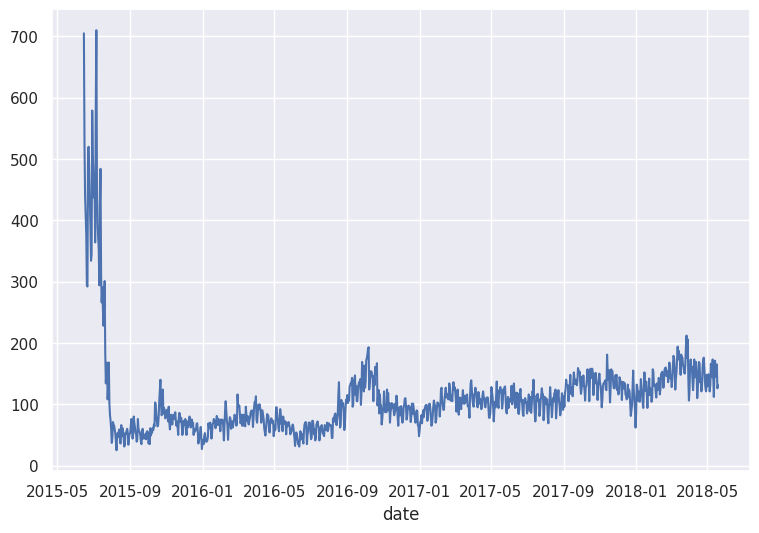

In [ ]:
# Визуализируем (ось x - день, ось y - количество).
# Не наблюдаем каких-то выбросов или пропусков данных, делаем вывод, что по времени нет каких-либо проблем.
events.groupby('date').user_id.nunique().plot().autoscale(tight=False)

In [ ]:
# Как распределены пользователи по количеству баллов, которое они набрали за курс:
user_events = events.pivot_table(
    index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0
).reset_index().rename_axis('', axis=1)

user_events

,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1
...,...,...,...,...,...
19229,26790,8,8,1,9
19230,26793,1,0,1,1
19231,26794,69,69,34,180
19232,26797,10,10,2,13


<Axes: >

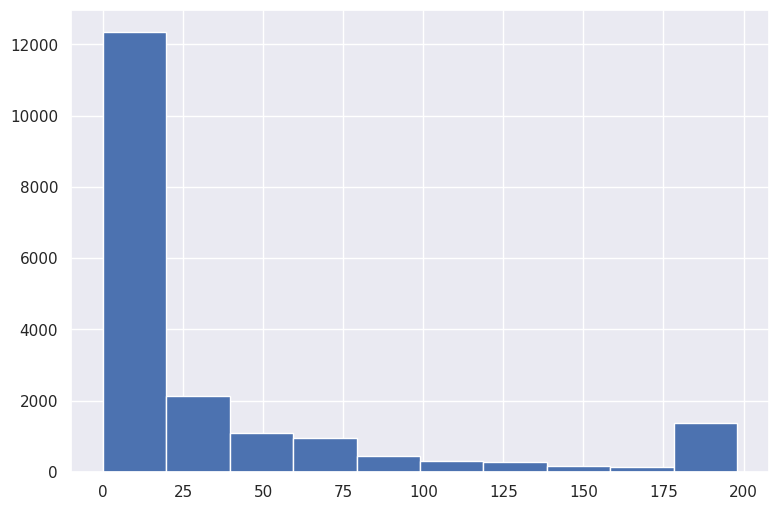

In [ ]:
# Ось x - количество решенных задач, ось y - количество пользователей:
user_events.passed.hist()

<Axes: >

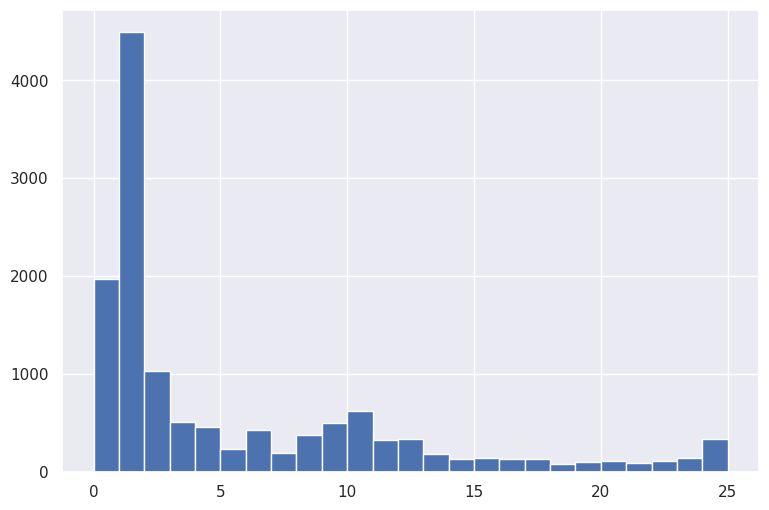

In [ ]:
# Около 2000 учащихся не решили ни одной задачи:
user_events.query('passed <= 25').passed.hist(bins=25)

In [ ]:
# 1972 пользователя, если быть точным:
user_events.query('passed == 0').shape[0]

1972

In [ ]:
# Правильные и неправильные ответы пользователей:
user_submissions = submissions.pivot_table(
    index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0
).reset_index().rename_axis('', axis=1)

user_submissions

,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1
...,...,...,...
9935,26787,3,0
9936,26790,1,0
9937,26794,33,9
9938,26797,2,0


In [ ]:
# Сколько уникальных дней учились пользователи:
unique_days = events.groupby('user_id').date.nunique().to_frame() \
    .rename(columns={'date': 'unique_days'})

unique_days

,unique_days
user_id,
1,1
2,2
3,7
5,2
7,1
...,...
26790,4
26793,1
26794,9


<Axes: >

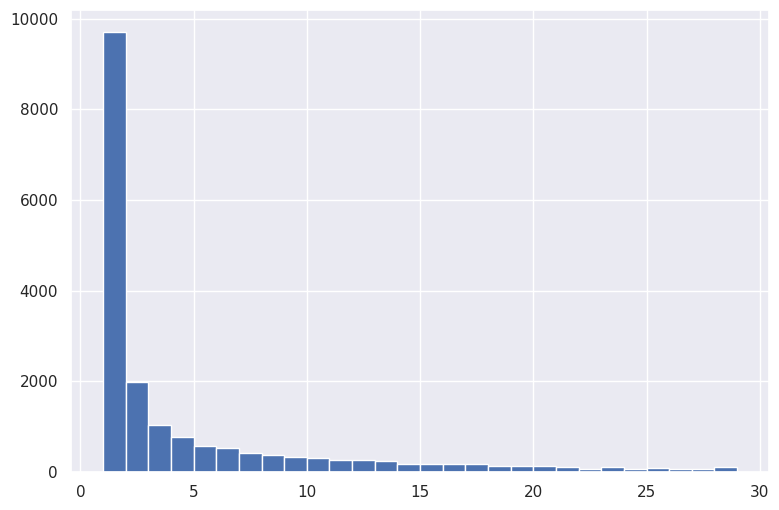

In [ ]:
# Визуализируем:
unique_days.query('unique_days < 30').unique_days.hist(bins=28)

In [ ]:
# 50% были на курсе один день и больше никогда не заходили.
# 30% учились 5 уникальных дней и более.
unique_days.describe(percentiles=[.51, .6, .61, .66, .67, .7, .71, .73, .74, .75, .76, .78, .79])

,unique_days
count,19234.000000
mean,6.088489
std,12.341683
min,1.000000
50%,1.000000
51%,2.000000
60%,2.000000
61%,3.000000
66%,3.000000
67%,4.000000


In [ ]:
# Чтобы получить сертификат, надо решить 170 задач.
# Получил сертификат - значит прошел курс.
PRACTICAL_STEPS_COUNT_FOR_PASSED_COURSE = 170

In [ ]:
# Посмотрим количество пройденных практических шагов:
users = user_events[['user_id', 'passed']].rename(columns={'passed': 'passed_practical_steps'})
users

,user_id,passed_practical_steps
0,1,0
1,2,9
2,3,87
3,5,11
4,7,1
...,...,...
19229,26790,8
19230,26793,0
19231,26794,69
19232,26797,10


In [ ]:
# Добавим флаг, прошел ли пользователь курс:
users['passed_course'] = users.passed_practical_steps >= PRACTICAL_STEPS_COUNT_FOR_PASSED_COURSE
users.passed_course = users.passed_course.map(int)
users

,user_id,passed_practical_steps,passed_course
0,1,0,0
1,2,9,0
2,3,87,0
3,5,11,0
4,7,1,0
...,...,...,...
19229,26790,8,0
19230,26793,0,0
19231,26794,69,0
19232,26797,10,0


In [ ]:
# Узнаем время первого захода на курс:
first_visits = events.groupby('user_id').timestamp.min().to_frame().rename(columns={'timestamp': 'first_visit'})
first_visits

,first_visit
user_id,
1,1472827464
2,1514383364
3,1434358476
5,1466156809
7,1521634660
...,...
26790,1451484016
26793,1510225031
26794,1495287049


In [ ]:
# И время последнего захода на курс:
last_visits = events.groupby('user_id').timestamp.max().to_frame().rename(columns={'timestamp': 'last_visit'})
last_visits

,last_visit
user_id,
1,1472827464
2,1519226966
3,1444581588
5,1499859939
7,1521634660
...,...
26790,1517495987
26793,1510225034
26794,1512035039


In [ ]:
# Добавим первый и последний заходы на курс:
users = users.merge(first_visits, on='user_id')
users = users.merge(last_visits, on='user_id')
users

,user_id,passed_practical_steps,passed_course,first_visit,last_visit
0,1,0,0,1472827464,1472827464
1,2,9,0,1514383364,1519226966
2,3,87,0,1434358476,1444581588
3,5,11,0,1466156809,1499859939
4,7,1,0,1521634660,1521634660
...,...,...,...,...,...
19229,26790,8,0,1451484016,1517495987
19230,26793,0,0,1510225031,1510225034
19231,26794,69,0,1495287049,1512035039
19232,26797,10,0,1508425316,1509995096


In [ ]:
# Количественное соотношение прошедших и непрошедших курс:
users.passed_course.value_counts()

0    17801
1     1433
Name: passed_course, dtype: int64

In [ ]:
# Процентное соотношение прошедших и непрошедших курс:
users.passed_course.value_counts(normalize=True)

0    0.925497
1    0.074503
Name: passed_course, dtype: float64

<Axes: xlabel='passed_course', ylabel='count'>

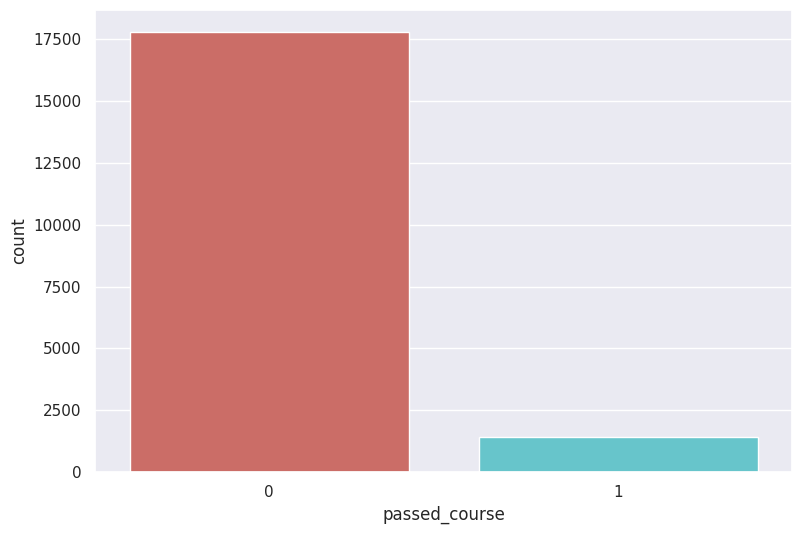

In [ ]:
# Визуализируем количество закончивших и незакончивших курс:
sns.countplot(x='passed_course', data=users, palette='hls')

In [ ]:
# ID прошедших курс пользователей:
passed_course_user_ids = users[users['passed_course'] == True].user_id
passed_course_user_ids

9           16
13          22
18          30
22          34
26          39
         ...  
19190    26740
19207    26763
19218    26777
19220    26779
19221    26781
Name: user_id, Length: 1433, dtype: int64

In [ ]:
# Отберем события пользователей, прошедших курс:
events_of_passed_course_users = events[events['user_id'].isin(passed_course_user_ids)]
events_of_passed_course_users

,step_id,timestamp,action,user_id,date
94,32815,1434342230,discovered,6646,2015-06-15
95,32815,1434342230,passed,6646,2015-06-15
96,32815,1434342230,viewed,6646,2015-06-15
97,32811,1434342233,passed,6646,2015-06-15
98,32811,1434342233,discovered,6646,2015-06-15
...,...,...,...,...,...
3479642,34026,1526756104,viewed,23194,2018-05-19
3479644,33901,1526756106,viewed,23194,2018-05-19
3479652,33901,1526756195,viewed,23194,2018-05-19
3479653,33899,1526756197,viewed,23194,2018-05-19


In [ ]:
# Узнаем время правильного решения 170-й задачи. Это и будет время окончания курса.
# Для этого соберем датафрейм из первых 170-ти событий успешного решения практического шага:
tmp = events_of_passed_course_users.query('action == "passed"') \
    .sort_values(['user_id', 'timestamp']) \
    .groupby('user_id') \
    .head(PRACTICAL_STEPS_COUNT_FOR_PASSED_COURSE)

tmp.head(PRACTICAL_STEPS_COUNT_FOR_PASSED_COURSE + 1)

,step_id,timestamp,action,user_id,date
282352,32815,1435674765,passed,16,2015-06-30
282363,32811,1435674778,passed,16,2015-06-30
282380,32929,1435674798,passed,16,2015-06-30
282385,32814,1435674800,passed,16,2015-06-30
282417,32812,1435674880,passed,16,2015-06-30
...,...,...,...,...,...
2826977,33983,1513093702,passed,16,2017-12-12
2826983,33984,1513093777,passed,16,2017-12-12
2827047,34041,1513094276,passed,16,2017-12-12
2827052,33939,1513094298,passed,16,2017-12-12


In [ ]:
# Максимальный таймстемп каждого пользователя - это время получения сертификата:
obtaining_certs = tmp.groupby('user_id').timestamp.max().to_frame() \
    .rename(columns={'timestamp': 'obtaining_cert'})

obtaining_certs

,obtaining_cert
user_id,
16,1513094298
22,1500036463
30,1509095682
34,1504794582
39,1459445025
...,...
26740,1456347416
26763,1436205266
26777,1436462092


In [ ]:
# Создадим датафрейм, поместим туда прошедших курс пользователей:
passed_course_users = users.query('passed_course == True')

# Добавим время получения сертификата:
passed_course_users = passed_course_users.merge(obtaining_certs, on='user_id')

passed_course_users

,user_id,passed_practical_steps,passed_course,first_visit,last_visit,obtaining_cert
0,16,196,1,1435674765,1513162585,1513094298
1,22,198,1,1498561010,1507142631,1500036463
2,30,198,1,1467307716,1510574287,1509095682
3,34,195,1,1493156230,1525626844,1504794582
4,39,198,1,1456943480,1502712399,1459445025
...,...,...,...,...,...,...
1428,26740,188,1,1444388456,1463224362,1456347416
1429,26763,193,1,1434350514,1436216740,1436205266
1430,26777,191,1,1434374498,1436605200,1436462092
1431,26779,196,1,1473155734,1520157100,1476952592


In [ ]:
# Узнаем, за сколько дней пользователи прошли курс:
passed_course_users['days_spent_on_obtaining_cert'] = \
    np.ceil(
        (passed_course_users['obtaining_cert'] - passed_course_users['first_visit']) / (24 * 60 * 60)
    ).map(int)

passed_course_users

,user_id,passed_practical_steps,passed_course,first_visit,last_visit,obtaining_cert,days_spent_on_obtaining_cert
0,16,196,1,1435674765,1513162585,1513094298,897
1,22,198,1,1498561010,1507142631,1500036463,18
2,30,198,1,1467307716,1510574287,1509095682,484
3,34,195,1,1493156230,1525626844,1504794582,135
4,39,198,1,1456943480,1502712399,1459445025,29
...,...,...,...,...,...,...,...
1428,26740,188,1,1444388456,1463224362,1456347416,139
1429,26763,193,1,1434350514,1436216740,1436205266,22
1430,26777,191,1,1434374498,1436605200,1436462092,25
1431,26779,196,1,1473155734,1520157100,1476952592,44


<Axes: >

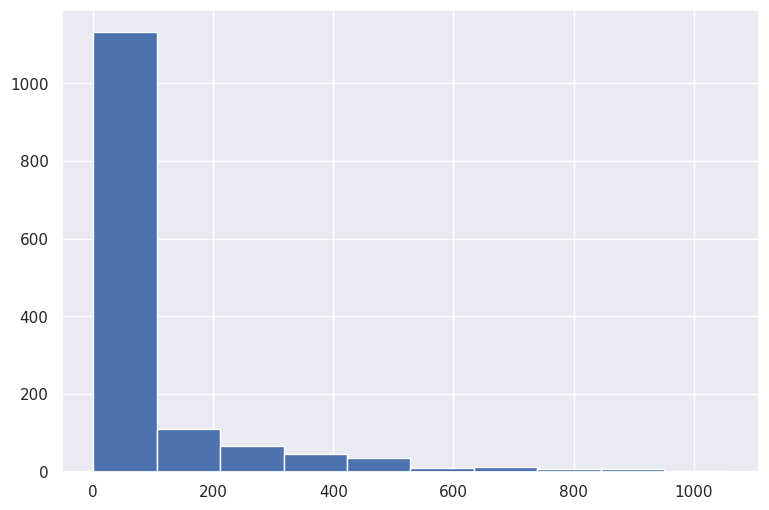

In [ ]:
# Ось x - количество дней, ось y - количество учеников:
passed_course_users['days_spent_on_obtaining_cert'].hist()

<Axes: >

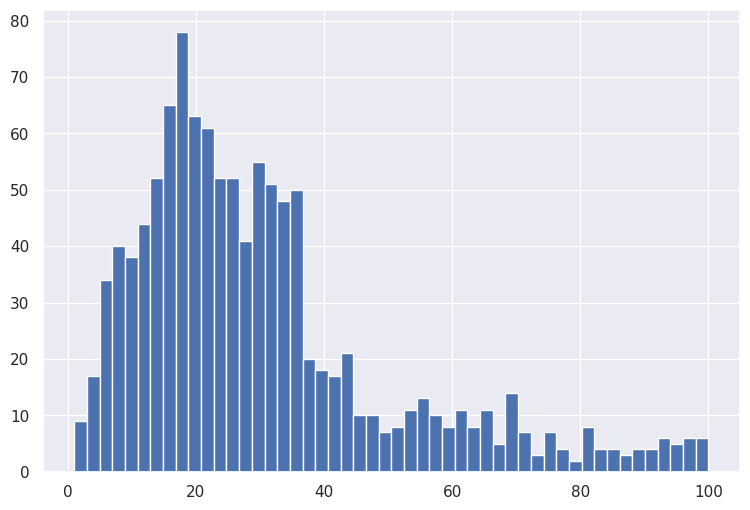

In [ ]:
passed_course_users.query('days_spent_on_obtaining_cert <= 100').days_spent_on_obtaining_cert.hist(bins=50)


In [ ]:
# Наблюдаем очень быстрое прохождение курса у 8-ми пользователей.
# Если не переводить значение в целые дни, то там будет от 30 до 45 мин у первых 8-ми пользователей.
# Может команда курса тестировала?
passed_course_users.sort_values('days_spent_on_obtaining_cert').head(10)

,user_id,passed_practical_steps,passed_course,first_visit,last_visit,obtaining_cert,days_spent_on_obtaining_cert
519,9104,195,1,1522098760,1522183769,1522111098,1
957,17191,190,1,1455013305,1458322391,1455024723,1
625,11061,196,1,1521015150,1523169005,1521017255,1
1138,21010,181,1,1482449434,1482475233,1482475149,1
564,9956,184,1,1463316278,1463380111,1463318306,1
1077,19805,198,1,1509741291,1512210943,1509744324,1
1220,22833,194,1,1464164406,1517842929,1464166049,1
651,11574,185,1,1478609068,1478629364,1478629003,1
248,4106,193,1,1458310371,1458484260,1458473308,2
1180,22059,197,1,1514928356,1515238451,1515182835,3


In [ ]:
passed_course_users['days_spent_on_obtaining_cert'].describe(percentiles=[.9, .95, .99])

# Сколько дней обучения брать в качестве порога?

# Например, считаем, что пользователь бросил курс,
# если он не получил сертификат и уже учится более 434 дней (95 персентиль).

# Пользователи, которые не имеют сертификат и учатся меньше 434 дней, будут в неопределенном статусе.
# Посмотрим, сколько таких пользователей будет при взятии различных порогов.

count    1433.000000
mean       92.387299
std       152.200695
min         1.000000
50%        31.000000
90%       283.800000
95%       434.000000
99%       747.440000
max      1056.000000
Name: days_spent_on_obtaining_cert, dtype: float64

In [ ]:
# Пользователи без сертификатов:
not_passed_course_users = users.query('passed_course == False')
not_passed_course_users

,user_id,passed_practical_steps,passed_course,first_visit,last_visit
0,1,0,0,1472827464,1472827464
1,2,9,0,1514383364,1519226966
2,3,87,0,1434358476,1444581588
3,5,11,0,1466156809,1499859939
4,7,1,0,1521634660,1521634660
...,...,...,...,...,...
19229,26790,8,0,1451484016,1517495987
19230,26793,0,0,1510225031,1510225034
19231,26794,69,0,1495287049,1512035039
19232,26797,10,0,1508425316,1509995096


In [ ]:
training_length_threshold = 747 * 24 * 60 * 60

# 11417 человек  начали проходить курс меньше чем 747 дня назад (99-й персентиль).
# 7530  человека начали проходить курс меньше чем 434 дня назад (95-й персентиль).
not_passed_course_users.query('first_visit + @training_length_threshold > @now').shape[0]

UndefinedVariableError: ignored

In [ ]:
# Мы потеряем 59.3% пользователей без сертификата в случае взятия 99-го персентиля в качестве порога.
# т.к. они не закончили курс и не бросили его.
# Мы потеряем 39.1% пользователей без сертификата в случае взятия 95-го персентиля в качестве порога.
not_passed_course_users.query('first_visit + @training_length_threshold > @now').shape[0] / users.shape[0]


In [ ]:
# Добавим время получения сертификата к событиям пользователей получивших сертификат:
events_of_passed_course_users = events_of_passed_course_users.merge(
    passed_course_users[['user_id', 'obtaining_cert']], on='user_id'
)

events_of_passed_course_users

In [ ]:
events_of_passed_course_users

In [ ]:
events_of_passed_course_users

In [ ]:
events_of_passed_course_users

In [ ]:
max_breaks_of_passed_course_users = events_of_passed_course_users \
    .query('timestamp <= obtaining_cert')[['user_id', 'timestamp']] \
    .groupby('user_id')['timestamp'] \
    .apply(list) \
    .apply(np.diff) \
    .apply(np.max) \
    .to_frame().rename(columns={'timestamp': 'max_break'})

max_breaks_of_passed_course_users

In [ ]:
max_breaks_of_passed_course_users['max_break'] = \
    np.ceil(
        max_breaks_of_passed_course_users['max_break'] / (24 * 60 * 60)
    ).map(int)

max_breaks_of_passed_course_users

In [ ]:
passed_course_users = passed_course_users.merge(max_breaks_of_passed_course_users, on='user_id')
passed_course_users

In [ ]:
passed_course_users['max_break'].hist()

In [ ]:
passed_course_users['max_break'].describe(percentiles=[.9, .95, .99])


In [ ]:
not_passed_course_user_ids = users.query('passed_course == False').user_id
not_passed_course_user_ids

In [ ]:
events_of_not_passed_course_users = events[events['user_id'].isin(not_passed_course_user_ids)]
events_of_not_passed_course_users

In [ ]:
max_breaks_of_not_passed_course_users = events_of_not_passed_course_users[['user_id', 'timestamp']] \
    .groupby('user_id')['timestamp'] \
    .apply(list) \
    .apply(lambda x: x + [now]) \
    .apply(np.diff) \
    .apply(np.max) \
    .to_frame().rename(columns={'timestamp': 'max_break'})

max_breaks_of_not_passed_course_users

In [ ]:
# Переведем секунды в дни:
max_breaks_of_not_passed_course_users['max_break'] = \
    np.ceil(
        max_breaks_of_not_passed_course_users['max_break'] / (24 * 60 * 60)
    ).map(int)

max_breaks_of_not_passed_course_users

In [ ]:
# Добавим максимальный перерыв к пользователям без сертификата:
not_passed_course_users = not_passed_course_users.merge(max_breaks_of_not_passed_course_users, on='user_id')
not_passed_course_users

In [ ]:
breaks_in_training_threshold = 536

In [ ]:
not_passed_course_users.query('max_break <= @breaks_in_training_threshold').shape[0]

In [ ]:
not_passed_course_users.query('max_break <= @breaks_in_training_threshold').shape[0] \
    / not_passed_course_users.shape[0]

In [ ]:
breaks_in_training_threshold


NameError: ignored

In [ ]:
users=users.merge(pd.concat([max_breaks_of_passed_course_users, max_breaks_of_not_passed_course_users]), on='user_id')
users

In [ ]:
users['is_gone'] = 0
users.loc[(users['passed_course']==0)&(users['max_break'] > breaks_in_training_threshold), 'is_gone']=1
users

KeyError: ignored

In [ ]:
users.groupby(['passed_course', 'is_gone'])['user_id'].count()

passed_course  is_gone
0              0          17801
1              0           1433
Name: user_id, dtype: int64

In [ ]:
users = users[(users['is_gone'] == True) | (users['passed_course'] == True)]
users

,user_id,passed_practical_steps,passed_course,first_visit,last_visit,is_gone
9,16,196,1,1435674765,1513162585,0
13,22,198,1,1498561010,1507142631,0
18,30,198,1,1467307716,1510574287,0
22,34,195,1,1493156230,1525626844,0
26,39,198,1,1456943480,1502712399,0
...,...,...,...,...,...,...
19190,26740,188,1,1444388456,1463224362,0
19207,26763,193,1,1434350514,1436216740,0
19218,26777,191,1,1434374498,1436605200,0
19220,26779,196,1,1473155734,1520157100,0


In [ ]:
users.groupby(['passed_course', 'is_gone'])['user_id'].count()

passed_course  is_gone
1              0          1433
Name: user_id, dtype: int64

In [ ]:
users['passed_course'].value_counts(normalize = True)

0    0.853191
1    0.146809
Name: passed_course, dtype: float64

In [ ]:
users = users.drop('passed_course', axis=1)


KeyError: ignored

In [ ]:
users

,user_id,passed_practical_steps,first_visit,last_visit,max_break,is_gone
0,1,0,1472827464,1472827464,625,1
2,3,87,1434358476,1444581588,952,1
8,14,3,1436366155,1436368676,1047,1
9,16,196,1435674765,1513162585,708,0
10,17,5,1465762612,1465765342,707,1
...,...,...,...,...,...,...
19220,26779,196,1473155734,1520157100,8,0
19221,26781,198,1487693786,1507540704,20,0
19223,26783,10,1434542952,1434543274,1068,1
19228,26789,2,1447263411,1447263419,921,1


<Axes: xlabel='is_gone', ylabel='count'>

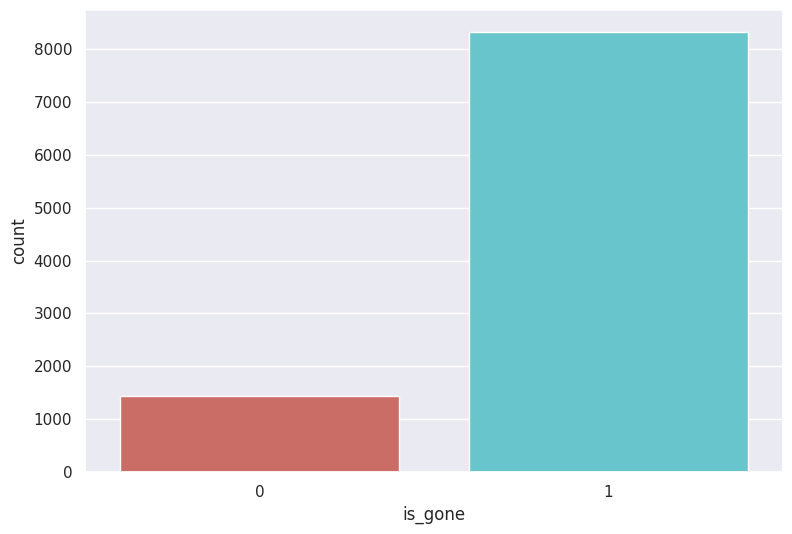

In [ ]:
sns.countplot(x='is_gone', data= users, palette='hls' )

In [ ]:
learning_time_threshold = 3 * 24 * 60 * 60


In [ ]:
events_train = events[events['user_id'].isin(users['user_id'])]
events_train = events_train.merge(first_visits, on='user_id')
events_train = events_train.query("timestamp - first_visit <= @learning_time_threshold")


In [ ]:
events_train.groupby('user_id').date.nunique().max()

4

In [ ]:
submissions_train = submissions[submissions['user_id'].isin(users['user_id'])]
submissions_train = submissions_train.merge(first_visits, on='user_id')
submissions_train = submissions_train.query('timestamp - first_visit <= @learning_time_threshold')
submissions_train


,step_id,timestamp,submission_status,user_id,date,first_visit
0,31971,1434349275,correct,15853,2015-06-15,1434345977
1,31972,1434348300,correct,15853,2015-06-15,1434345977
4,31976,1434348123,wrong,15853,2015-06-15,1434345977
5,31976,1434348188,correct,15853,2015-06-15,1434345977
7,31977,1434347371,correct,15853,2015-06-15,1434345977
...,...,...,...,...,...,...
330465,120745,1476419925,wrong,10312,2016-10-14,1476417044
330466,120745,1476419953,correct,10312,2016-10-14,1476417044
330467,120745,1476767714,correct,21817,2016-10-18,1476767576
330470,120745,1478563508,correct,26766,2016-11-08,1478561209


In [ ]:
submissions_train.groupby('user_id')['date'].nunique().max(
)

4

In [ ]:
X = users[['user_id', 'is_gone']]
days_of_training = submissions_train.groupby('user_id').date.nunique().to_frame() \
    .rename(columns={'date': 'days_of_training'})
days_of_training

,days_of_training
user_id,
3,1
14,1
16,3
17,1
22,3
...,...
26777,3
26778,1
26779,2


In [ ]:
steps_tried = submissions_train.groupby('user_id').step_id.nunique().to_frame() \
    .rename(columns={'step_id': 'tasks_tried'})
steps_tried


,tasks_tried
user_id,
3,4
14,1
16,23
17,1
22,20
...,...
26777,12
26778,1
26779,13


In [ ]:
submission_statuses = submissions_train.pivot_table(
    index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0
)


In [ ]:
submission_statuses

submission_status,correct,wrong
user_id,,
3,4,4
14,0,1
16,23,27
17,0,2
22,20,11
...,...,...
26777,12,14
26778,1,0
26779,13,5


In [ ]:
viewed = events_train.pivot_table(index='user_id', columns = 'action', values='step_id', aggfunc='count', fill_value=0).reset_index().rename_axis('', axis=1)[['user_id', 'viewed']]

In [ ]:
X = X.merge(days_of_training, on='user_id', how='outer')
X = X.merge(steps_tried, on='user_id', how='outer')
X = X.merge(submission_statuses, on='user_id', how='outer')
X = X.merge(viewed, on='user_id')
X

,user_id,is_gone,days_of_training,tasks_tried,correct,wrong,viewed
0,1,1,NaN,NaN,NaN,NaN,1
1,3,1,1.0,4.0,4.0,4.0,20
2,14,1,1.0,1.0,0.0,1.0,9
3,16,0,3.0,23.0,23.0,27.0,132
4,17,1,1.0,1.0,0.0,2.0,13
...,...,...,...,...,...,...,...
9756,26779,0,2.0,13.0,13.0,5.0,44
9757,26781,0,NaN,NaN,NaN,NaN,6
9758,26783,1,1.0,2.0,2.0,0.0,20
9759,26789,1,NaN,NaN,NaN,NaN,2


In [ ]:
X['correct_ratio']= X['correct']/(X['correct']+X['wrong'])
X = X.fillna(0)
for col in ['days_of_training', 'tasks_tried', 'correct', 'wrong']:
    X[col] = X[col].map(int)
X = X.rename_axis('', axis=1).set_index('user_id')
X

,is_gone,days_of_training,tasks_tried,correct,wrong,viewed,correct_ratio
user_id,,,,,,,
1,1,0,0,0,0,1,0.000000
3,1,1,4,4,4,20,0.500000
14,1,1,1,0,1,9,0.000000
16,0,3,23,23,27,132,0.460000
17,1,1,1,0,2,13,0.000000
...,...,...,...,...,...,...,...
26779,0,2,13,13,5,44,0.722222
26781,0,0,0,0,0,6,0.000000
26783,1,1,2,2,0,20,1.000000


In [ ]:
# Соберем y:
y = X['is_gone']

# Удалим колонку "is_gone" из X:
X = X.drop(['is_gone'], axis=1)
X

,days_of_training,tasks_tried,correct,wrong,viewed,correct_ratio
user_id,,,,,,
1,0,0,0,0,1,0.000000
3,1,4,4,4,20,0.500000
14,1,1,0,1,9,0.000000
16,3,23,23,27,132,0.460000
17,1,1,0,2,13,0.000000
...,...,...,...,...,...,...
26779,2,13,13,5,44,0.722222
26781,0,0,0,0,6,0.000000
26783,1,2,2,0,20,1.000000


In [ ]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

NameError: ignored

In [ ]:
X_train.shape


NameError: ignored

In [ ]:
X_test.shape


NameError: ignored

In [ ]:
grid_search_cv_clf = GridSearchCV(tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=10, random_state=0), {'max_depth':range(1, 5)}, cv=5)

In [ ]:
grid_search_cv_clf.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              min_samples_leaf=10,
                                              random_state=0),
             param_grid={'max_depth': range(1, 5)})

In [ ]:
# Посмотрим лучшую модель:
best_clf = grid_search_cv_clf.best_estimator_
best_clf

DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=10,
                       random_state=0)

In [ ]:
# Посмотрим точность на тестовых данных:
best_clf.score(X_test, y_test)

0.8774053382991931

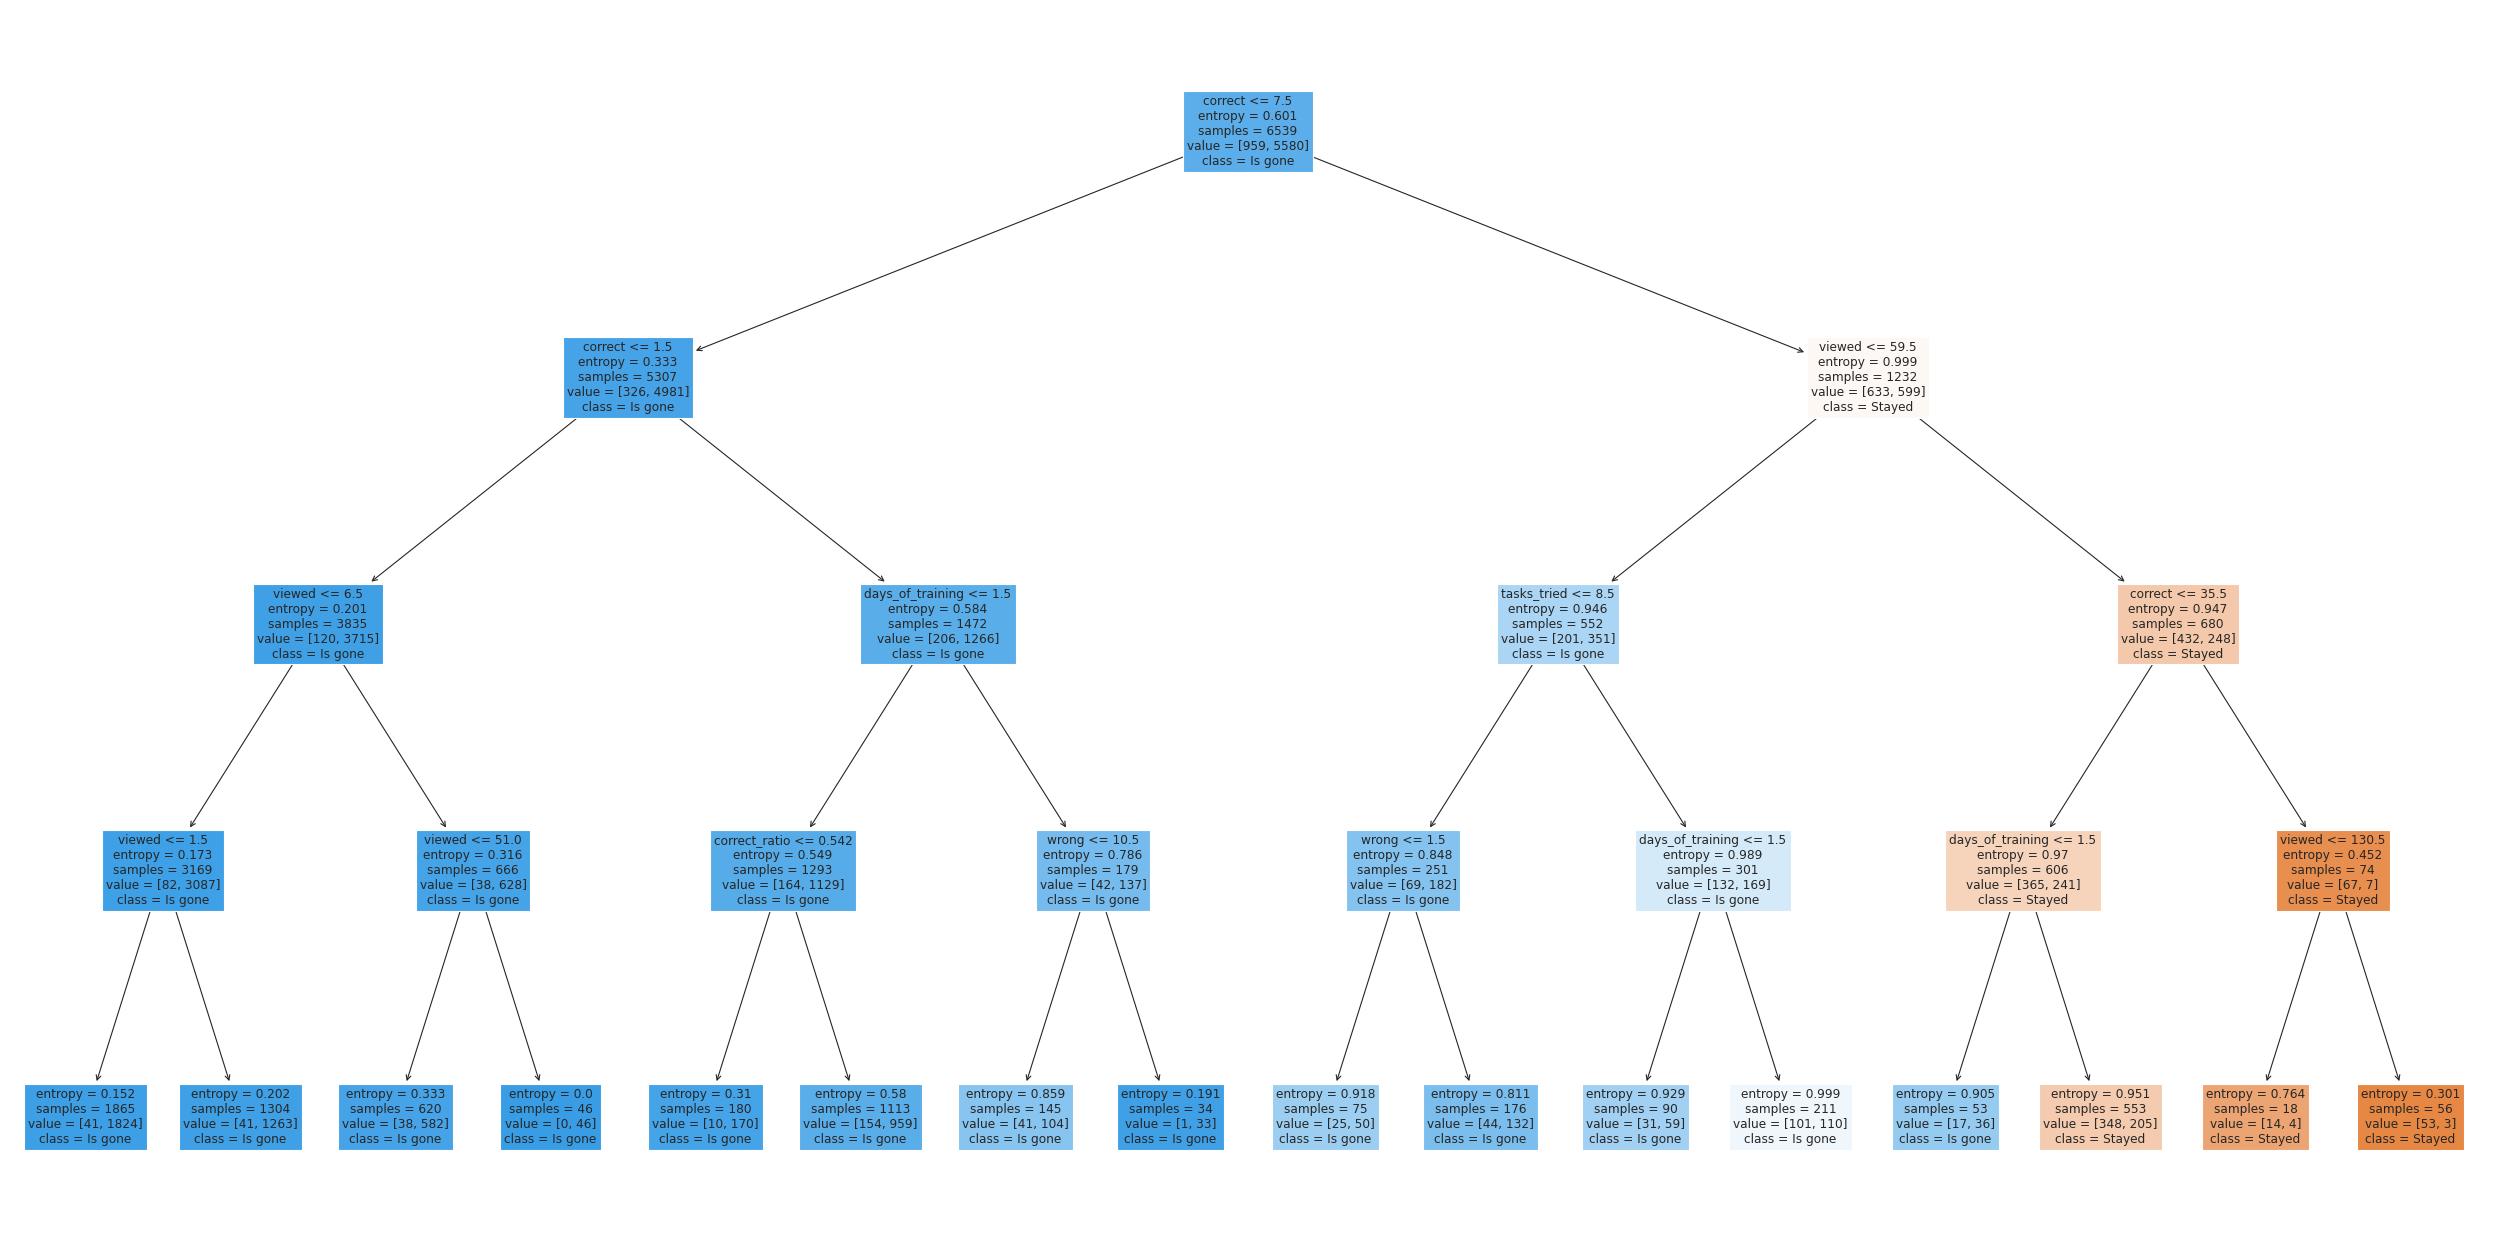

In [ ]:
plt.figure(figsize=(40, 20), dpi=80)
tree.plot_tree(best_clf, feature_names=X.columns ,filled=True, class_names=['Stayed', 'Is gone']);

In [ ]:
clf= LogisticRegressionCV(cv=5, random_state = 0 )
clf.fit(X_train, y_train)

LogisticRegressionCV(cv=5, random_state=0)

In [ ]:
cross_val_score(clf, X_train, y_train, cv=5).mean()

0.881020452093994

In [ ]:
clf.score(X_test, y_test)


0.8811297330850404

https://www.codecamp.ru/blog/logistic-regression-python/
Пример логистической регрессии с данного сайта


In [ ]:
import pandas as pd
import numpy as np
from sklearn. model_selection import train_test_split
from sklearn. linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
url = "https://raw.githubusercontent.com/Statology/Python-Guides/main/default.csv"
data = pd.read_csv(url)


,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879
...,...,...,...,...
9995,0,0,711.555020,52992.378914
9996,0,0,757.962918,19660.721768
9997,0,0,845.411989,58636.156984
9998,0,0,1569.009053,36669.112365


In [ ]:
data[0:6]

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879
5,0,1,919.588530,7491.558572


In [ ]:
X = data[['student', 'balance', 'income']]
y = data['default']
X_train,X_test,y_train,y_test = train_test_split (X,y,test_size=0.3,random_state=0)


In [ ]:
log_regression = LogisticRegression()
log_regression.fit(X_train, y_train)
y_pred = log_regression.predict(X_test)

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[2870,   17],
       [  93,   20]])

In [ ]:
print(" Accuracy:",metrics. accuracy_score (y_test, y_pred))

 Accuracy: 0.9633333333333334


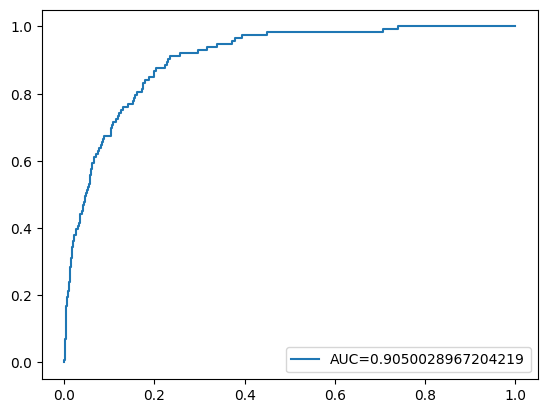

In [ ]:
y_pred_proba = log_regression.predict_proba(X_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label= 'AUC='+str(auc))
plt.legend(loc=4)
plt.show()

https://habr.com/ru/companies/skillfactory/articles/701530/
Опять про логистические регрессии


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing as preprocessing
from sklearn import linear_model
from sklearn.model_selection import cross_validate
import sklearn.model_selection
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import learning_curve
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import explained_variance_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.feature_selection import RFE
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


In [ ]:
#import the dataset and take a look at it
df_all = pd.read_csv('/content/drive/MyDrive/WORKING/Курсы/DS/Дата-сеты с курса для начинающих по DS/archive.zip', header = 0, compression='zip')
df_all.head(10)
#df_all.columns

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [ ]:
featureConCols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
corr = df_all[featureConCols].corr()
corr

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
V1,1.000000e+00,4.135835e-16,-1.227819e-15,-9.215150e-16,1.812612e-17,-6.506567e-16,-1.005191e-15,-2.433822e-16,-1.513678e-16,7.388135e-17,...,4.654551e-16,-2.457409e-16,-4.290944e-16,6.168652e-16,-4.425156e-17,-9.605737e-16,-1.581290e-17,1.198124e-16,2.083082e-15,-0.227709
V2,4.135835e-16,1.000000e+00,3.243764e-16,-1.121065e-15,5.157519e-16,2.787346e-16,2.055934e-16,-5.377041e-17,1.978488e-17,-3.991394e-16,...,2.506675e-16,-8.480447e-17,1.526333e-16,1.634231e-16,1.247925e-17,-4.478846e-16,2.057310e-16,-4.966953e-16,-5.093836e-16,-0.531409
V3,-1.227819e-15,3.243764e-16,1.000000e+00,4.711293e-16,-6.539009e-17,1.627627e-15,4.895305e-16,-1.268779e-15,5.568367e-16,1.156587e-15,...,-9.316409e-16,5.706192e-17,-1.133902e-15,-4.983035e-16,2.686834e-19,-1.104734e-15,-1.238062e-16,1.045747e-15,9.775546e-16,-0.210880
V4,-9.215150e-16,-1.121065e-15,4.711293e-16,1.000000e+00,-1.719944e-15,-7.491959e-16,-4.104503e-16,5.697192e-16,6.923247e-16,2.232685e-16,...,-1.857247e-16,-1.949553e-16,-6.276051e-17,9.164206e-17,1.584638e-16,6.070716e-16,-4.247268e-16,3.977061e-17,-2.761403e-18,0.098732
V5,1.812612e-17,5.157519e-16,-6.539009e-17,-1.719944e-15,1.000000e+00,2.408382e-16,2.715541e-16,7.437229e-16,7.391702e-16,-5.202306e-16,...,-3.554057e-16,-3.920976e-16,1.253751e-16,-8.428683e-18,-1.149255e-15,4.808532e-16,4.319541e-16,6.590482e-16,-5.613951e-18,-0.386356
V6,-6.506567e-16,2.787346e-16,1.627627e-15,-7.491959e-16,2.408382e-16,1.000000e+00,1.191668e-16,-1.104219e-16,4.131207e-16,5.932243e-17,...,-1.858755e-16,5.833316e-17,-4.705235e-19,1.046712e-16,-1.071589e-15,4.562861e-16,-1.357067e-16,-4.452461e-16,2.594754e-16,0.215981
V7,-1.005191e-15,2.055934e-16,4.895305e-16,-4.104503e-16,2.715541e-16,1.191668e-16,1.000000e+00,3.344412e-16,1.122501e-15,-7.492834e-17,...,9.379684e-16,-2.027779e-16,-8.898922e-16,-4.387401e-16,7.434913e-18,-3.094082e-16,-9.657637e-16,-1.782106e-15,-2.776530e-16,0.397311
V8,-2.433822e-16,-5.377041e-17,-1.268779e-15,5.697192e-16,7.437229e-16,-1.104219e-16,3.344412e-16,1.000000e+00,4.356078e-16,-2.801370e-16,...,2.033737e-16,3.892798e-16,2.026927e-16,6.377260e-17,-1.047097e-16,-4.653279e-16,-1.727276e-16,1.299943e-16,-6.200930e-16,-0.103079
V9,-1.513678e-16,1.978488e-17,5.568367e-16,6.923247e-16,7.391702e-16,4.131207e-16,1.122501e-15,4.356078e-16,1.000000e+00,-4.642274e-16,...,-2.343720e-16,1.936953e-16,-7.071869e-16,-5.214137e-16,-1.430343e-16,6.757763e-16,-7.888853e-16,-6.709655e-17,1.110541e-15,-0.044246
V10,7.388135e-17,-3.991394e-16,1.156587e-15,2.232685e-16,-5.202306e-16,5.932243e-17,-7.492834e-17,-2.801370e-16,-4.642274e-16,1.000000e+00,...,-1.331556e-15,1.177547e-15,-6.418202e-16,3.214491e-16,-1.355885e-16,-2.846052e-16,-3.028119e-16,-2.197977e-16,4.864782e-17,-0.101502


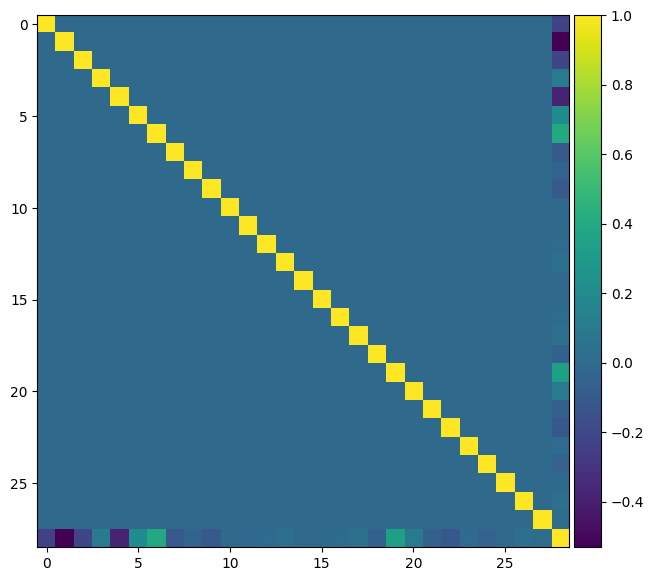

In [ ]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(121)
im1 = ax1.imshow(corr, interpolation='None')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

In [ ]:
#Report the distribution with target
feature_names = featureConCols
feature_names

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount']

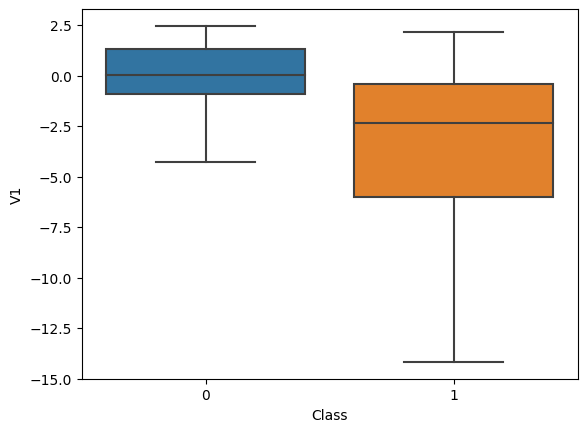

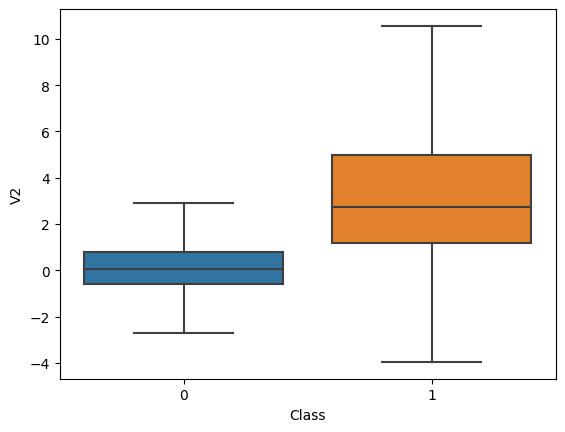

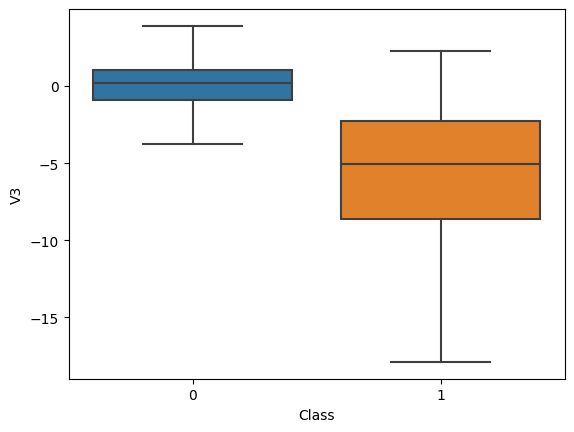

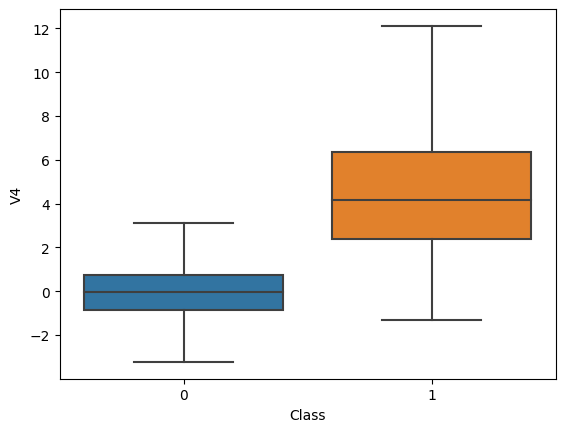

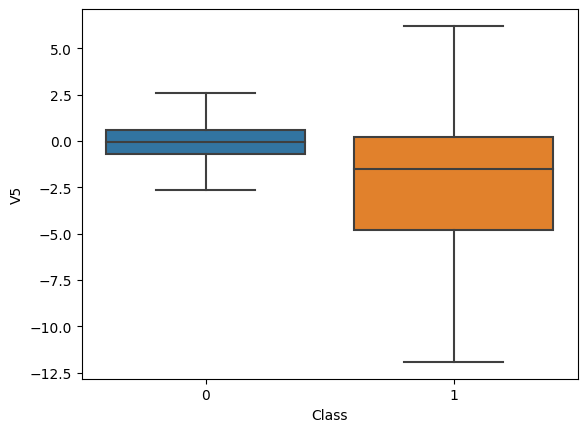

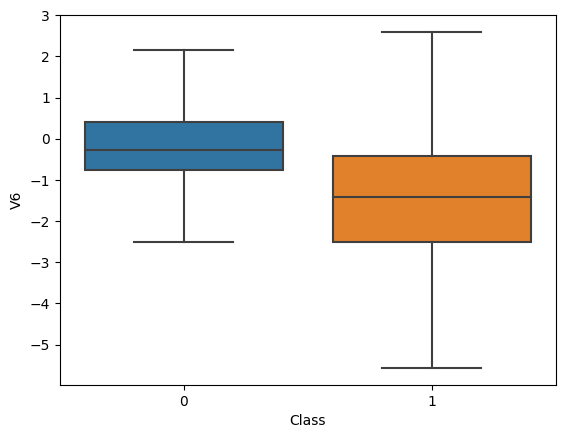

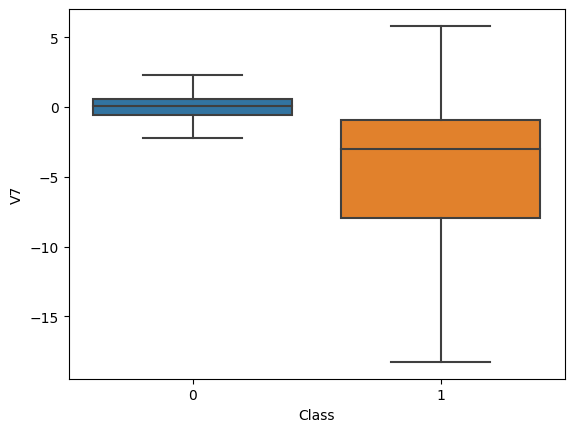

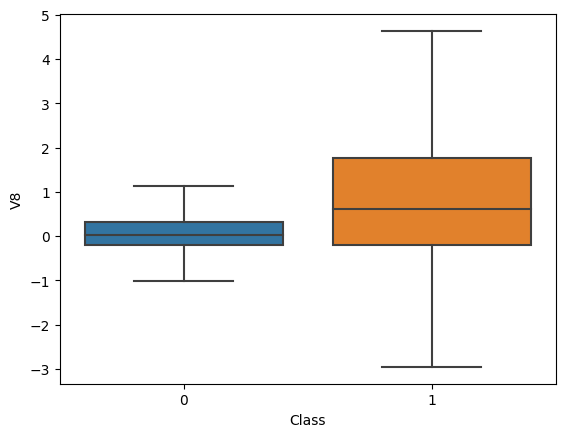

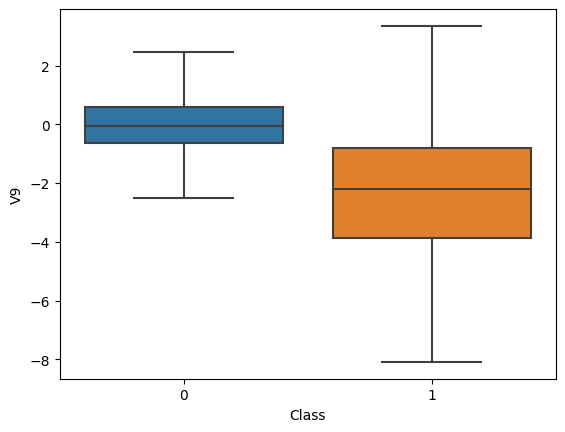

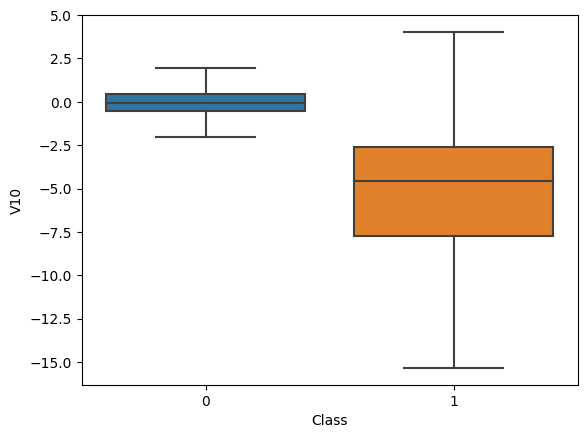

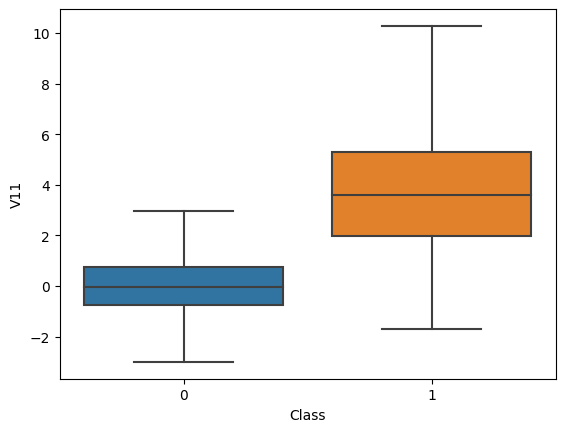

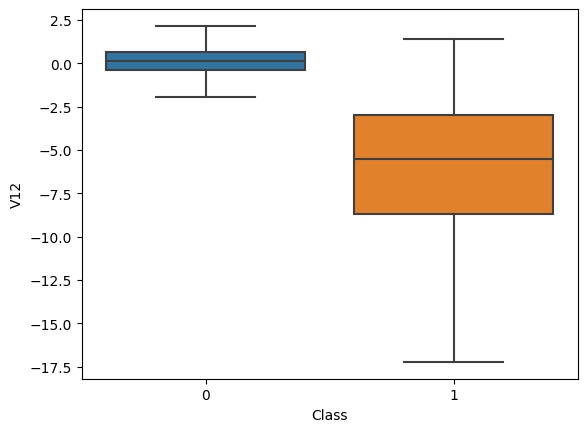

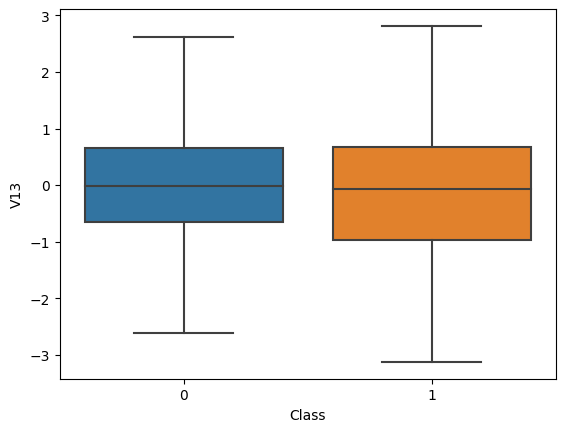

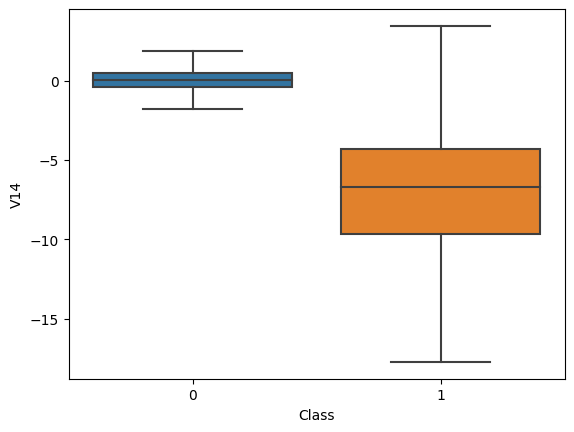

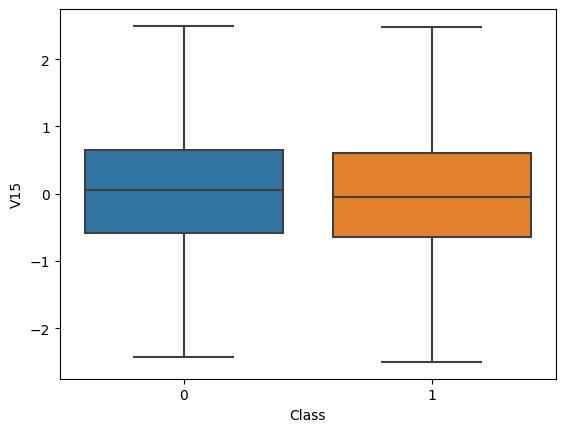

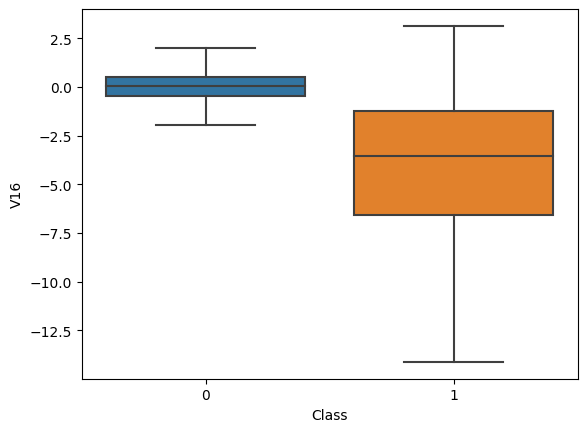

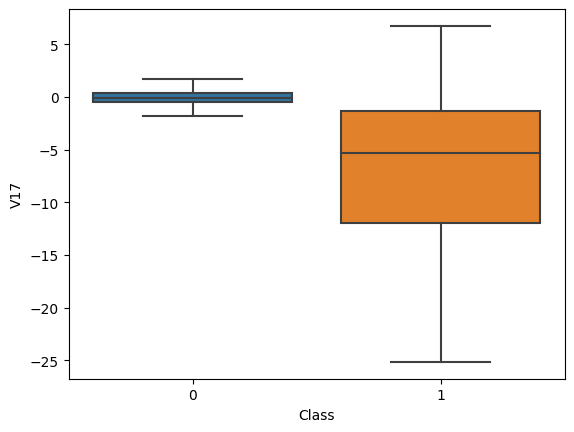

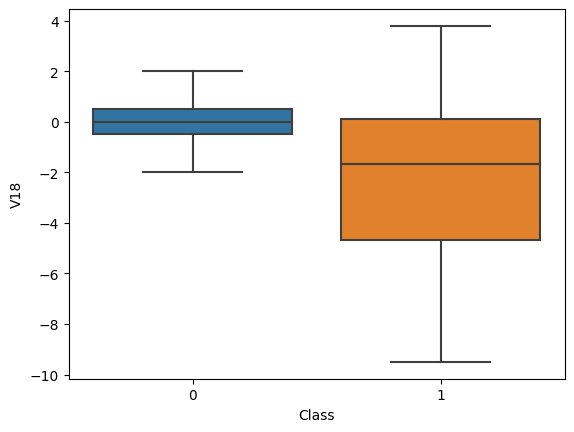

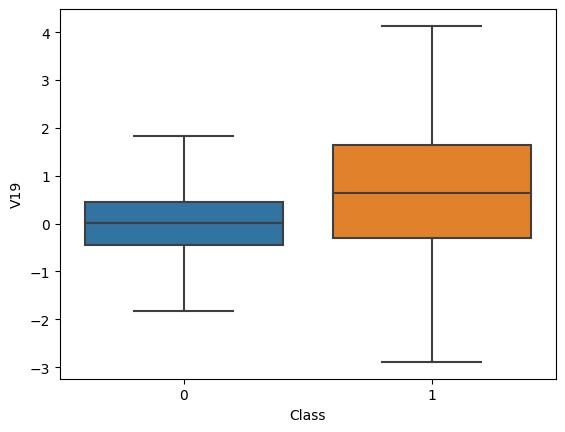

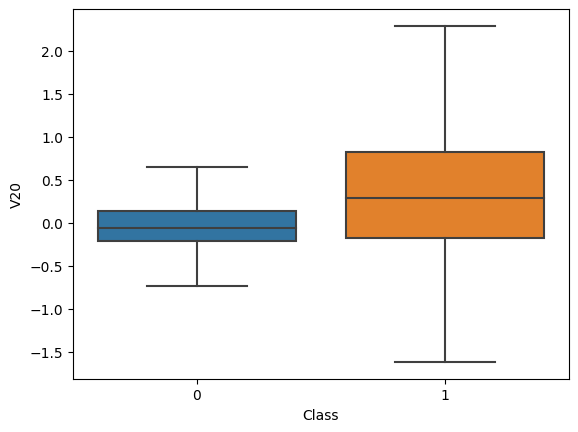

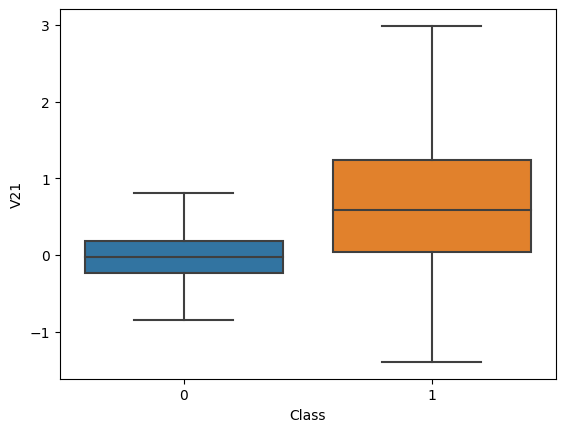

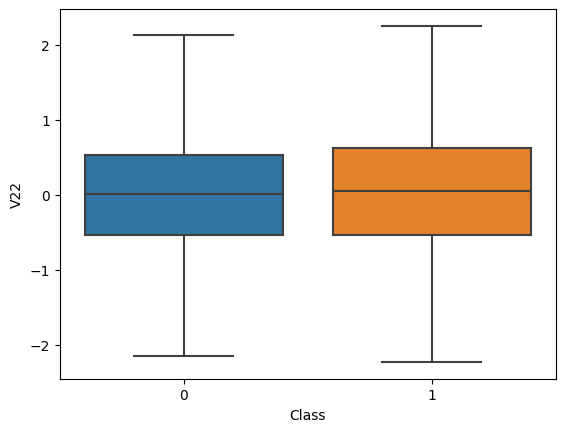

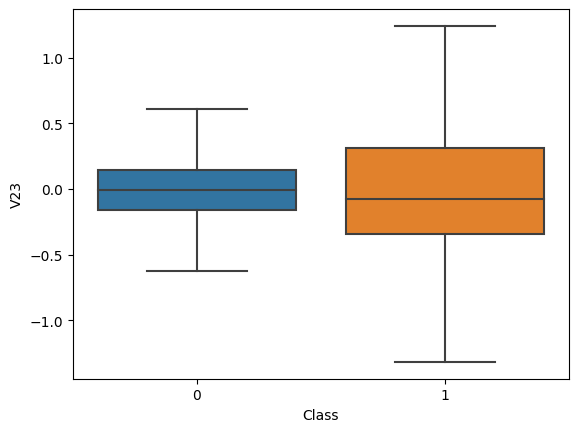

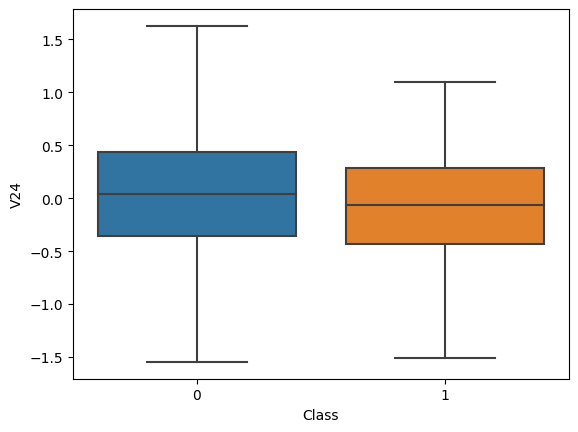

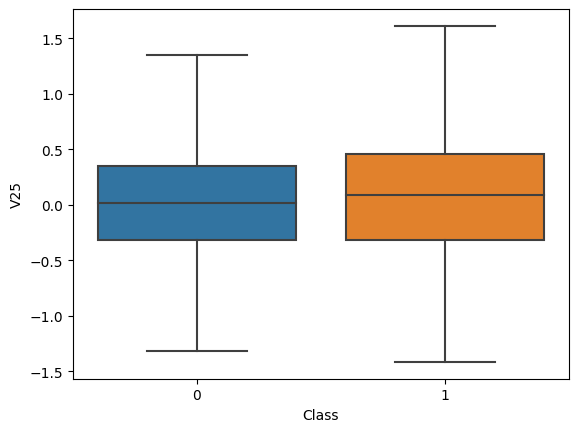

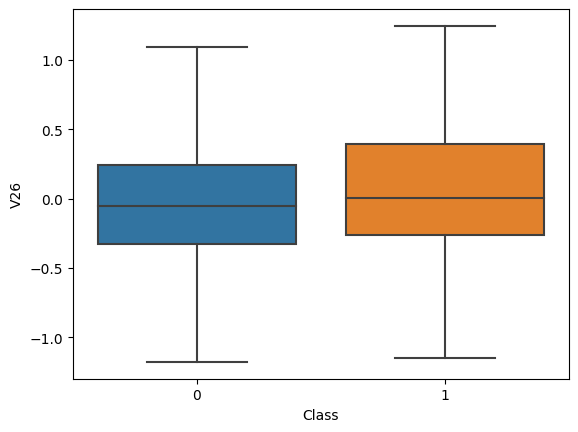

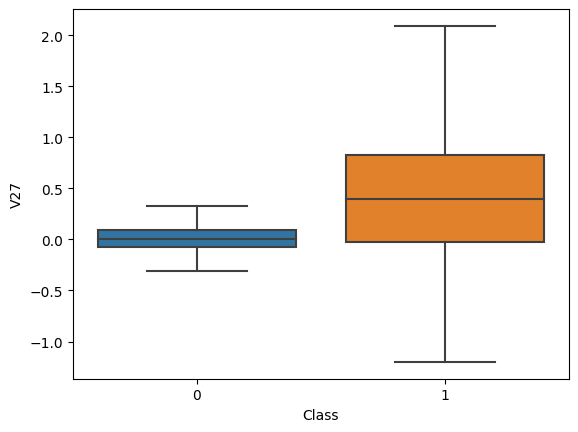

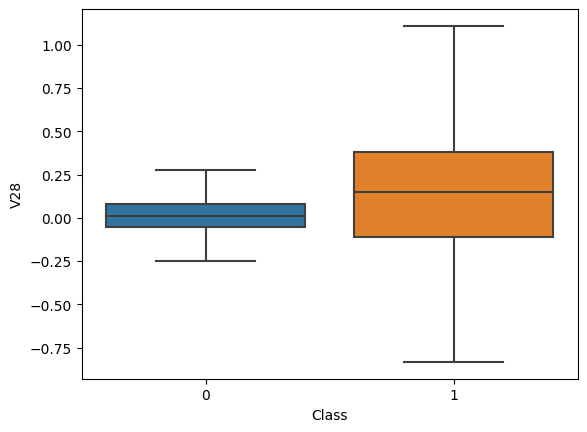

In [ ]:
for i in range(len(feature_names)-1):
  figure=plt.figure()
  ax = sns.boxplot(x = 'Class', y=feature_names[i], data=df_all,showfliers = False )

Class 0:  284315
Class 1:  492
Proportion:  577.88 : 1


<Axes: title={'center': 'Count(target)'}>

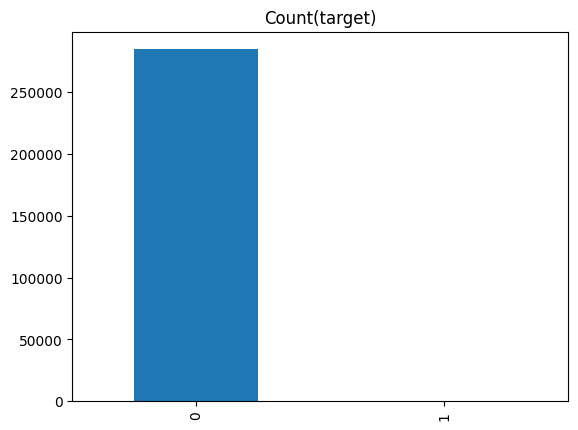

In [ ]:
target_count =df_all['Class'].value_counts()
print("Class 0: ", target_count[0])
print("Class 1: ", target_count[1])
print("Proportion: ", round(target_count[0]/target_count[1], 2) ,': 1')
df_all['Class'].value_counts().plot(kind = 'bar', title = 'Count(target)')


In [ ]:
# Split the database into training and testing set
df = df_all.drop(['Time'], axis = 1)
df_target = df['Class']
X_train, X_test, y_train, y_test = train_test_split(df, df_target, test_size=0.2)

# Data preprocessing to transfer all variables into array
scaler = preprocessing.StandardScaler()
vec = DictVectorizer(sparse = False)

def Data_preprocessing(X,y):

    #1. Numerical vars into vector
    X_dataFeatureCon = X[featureConCols]
    X_dictCon = X_dataFeatureCon.T.to_dict().values()

    #2. Keep a dataframe of concat database before scaling
    X_all = X_dataFeatureCon

    #3. Vectorizing and scaling the nummerical variabled into range [-1,1]
    X_vec_con = vec.fit_transform(X_dictCon)
    X_vec_con = scaler.fit_transform(X_vec_con)
    X_vec = X_vec_con

    #5. Conver target into array
    y_vec = y.to_numpy()

    return X_vec, y_vec, X_all

  # Apply the Data_preprocessing function on training set and testing set
X_train_vec, y_train_vec, X_train_frame = Data_preprocessing(X_train, y_train)
X_test_vec,  y_test_vec, X_test_frame  = Data_preprocessing(X_test, y_test)

print('X Train shape is : ', X_train_vec.shape)
print('X Train DataFrame shape is: ', X_train_frame.shape)
print('Y Train shape is : ', y_train_vec.shape)
print('X Test shape is: ', X_test_vec.shape)
print('X Test DataFrame shape is: ', X_test_frame.shape)
print('Y Test shape is: ', y_test_vec.shape)

X Train shape is :  (227845, 29)
X Train DataFrame shape is:  (227845, 29)
Y Train shape is :  (227845,)
X Test shape is:  (56962, 29)
X Test DataFrame shape is:  (56962, 29)
Y Test shape is:  (56962,)


In [ ]:
count_class_0, count_class_1 = df_target.value_counts()
print(count_class_0)
print(count_class_1)
df_class_0 = df_all[df_all['Class']==0]
df_class_1 = df_all[df_all['Class']==1]


284315
492


In [ ]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)
print('Random under-sampling:')
print(df_test_under['Class'].value_counts())


Random under-sampling:
0    492
1    492
Name: Class, dtype: int64


<Axes: title={'center': 'Count (target)'}>

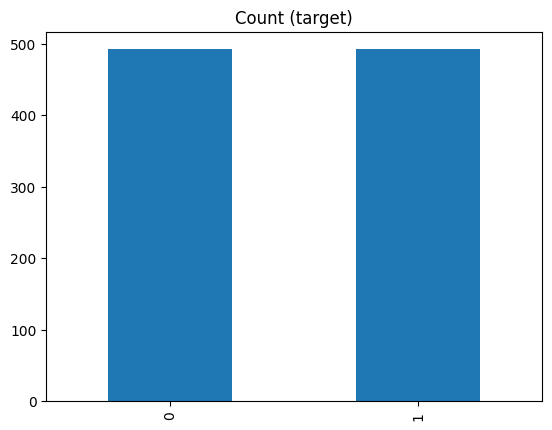

In [ ]:
df_test_under['Class'].value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
df_test_under['Class'].value_counts()

0    492
1    492
Name: Class, dtype: int64

In [ ]:
df_class_1_over= df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis = 0)


Random over-sampling:
0    284315
1    284315
Name: Class, dtype: int64


<Axes: title={'center': 'Count (target)'}>

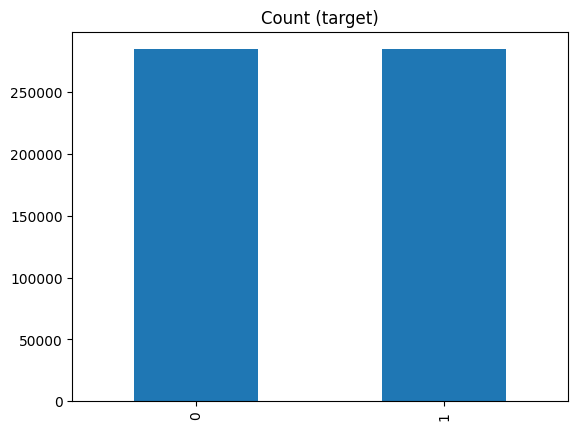

In [ ]:
print('Random over-sampling:')
print(df_test_over['Class'].value_counts())

df_test_over['Class'].value_counts().plot(kind='bar', title='Count (target)')

Accuracy: 99.91%
Confusion matrix:
 [[56844    13]
 [   39    66]]


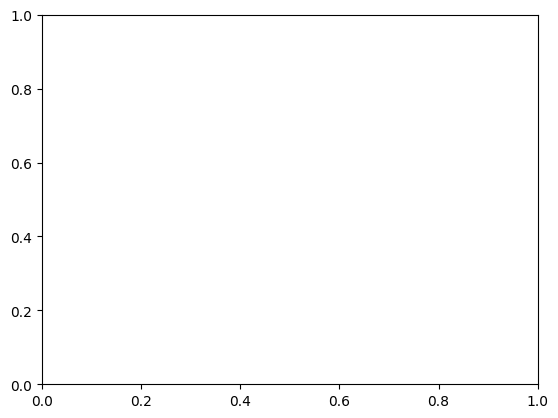

In [ ]:
# Model 1: Simple logistic regression with l2 regularization
#1. Model parameters
model1 = linear_model.LogisticRegression(C=1.0, penalty='l2', tol=1e-6)
model1.fit(X_train_vec, y_train_vec)
y_pred = model1.predict(X_test_vec)
accuracy = accuracy_score(y_test_vec, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

conf_mat = confusion_matrix(y_true=y_test_vec, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)


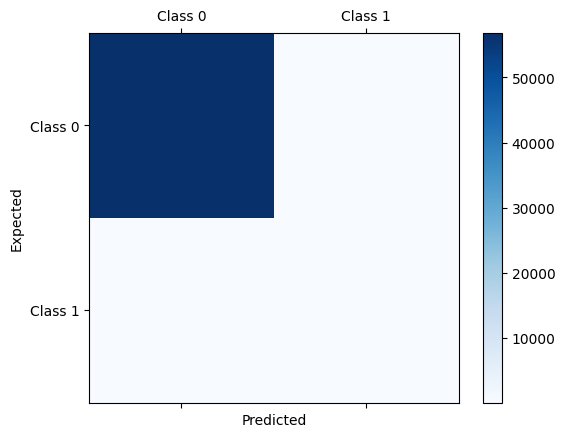

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56857
           1       0.84      0.63      0.72       105

    accuracy                           1.00     56962
   macro avg       0.92      0.81      0.86     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()
report = classification_report(y_test_vec, y_pred)
print(report)


(787, 30)
(197, 30)
(787,)
(197,)
X Train shape is :  (787, 29)
Y Train shape is :  (787,)
X Test shape is:  (197, 29)
Y Test shape is:  (197,)
Accuracy: 93.91%
Confusion matrix:
 [[92  1]
 [11 93]]


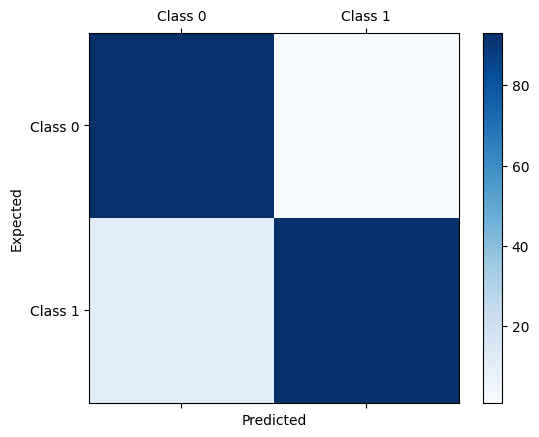

              precision    recall  f1-score   support

           0       0.89      0.99      0.94        93
           1       0.99      0.89      0.94       104

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197



In [ ]:
df_u = df_test_under.drop(['Time'], axis = 1)
df_u_target = df_u['Class']
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(df_u, df_u_target, test_size=0.2)
print(X_train_under.shape)
print(X_test_under.shape)
print(y_train_under.shape)
print(y_test_under.shape)

X_train_under_vec, y_train_under_vec, X_train_under_frame = Data_preprocessing(X_train_under, y_train_under)
X_test_under_vec,  y_test_under_vec , X_test_under_frame = Data_preprocessing(X_test_under, y_test_under)
print('X Train shape is : ', X_train_under_vec.shape)
print('Y Train shape is : ', y_train_under_vec.shape)
print('X Test shape is: ', X_test_under_vec.shape)
print('Y Test shape is: ', y_test_under_vec.shape)
model2 = linear_model.LogisticRegression(C=1.0, penalty='l2', tol=1e-6)
model2.fit(X_train_under_vec, y_train_under_vec)

y_pred = model2.predict(X_test_under_vec)
accuracy = accuracy_score(y_test_under_vec, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

conf_mat = confusion_matrix(y_true=y_test_under_vec, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

Labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()
report = classification_report(y_test_under_vec, y_pred)
print(report)


In [ ]:
report = classification_report(y_test_under_vec, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.94      0.93      0.94       109
           1       0.91      0.93      0.92        88

    accuracy                           0.93       197
   macro avg       0.93      0.93      0.93       197
weighted avg       0.93      0.93      0.93       197



In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,
                        train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
    """
    Plot learning curve of applied data model.
    ----------
    estimator : Classification
    title : title of plot
    X : features in numpy
    y : tearget in matrix
    ylim : tuple with (ymin, ymax)
    cv : cross-validation fold default as 3
    n_jobs :
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    if plot:
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel(u"Training examples")
        plt.ylabel(u"Score")
        plt.gca().invert_yaxis()
        plt.grid()

        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,
                         alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std,
                         alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"Cross-validation score")

        plt.legend(loc="best")

        plt.draw()
        plt.gca().invert_yaxis()
        plt.show()

    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff